# 1. Movimiento del péndulo con ángulos pequeños
Los ángulos pequeños que usaremos para este movimiento se calcularon en el archivo "Ángulos Pequeños.ipynb", en este mismo directorio.

In [1]:
#Importamos las librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import pandas as pd

#Importamos el rango de valores que consideramos pequeños. Estos valores se calcularon en Ángulos Pequeños.ipynb
%store -r theta_peq

## 1.1. Análisis de los Datos Experimentales

### 1.1.1. Definición de la función (para análisis de cualquier set de datos experimentales del proyecto)

In [2]:
def anDatExp (loc, fmt, cic=None, sets=10):
    
    """
    Esta función importa los datos experimentales y los promedia dejando
    como cantidad de datos la cantidad del set con menor cantidad de datos.
    Además, la función siempre genera una grafica, la cual puede ser los
    datos de ángulos promediados con respecto a su tiempo, o, cuando se
    especifican los rangos en los que pueden estar los picos del periodo que
    se desea, se grafica esos puntos dentro de ese rango de tiempo, además,
    se calcula el periodo y la aceleración de gravedad en base a esos puntos
    seleccionados.
    
    Params:
    loc:
        String. Dirección de los archivos a analizar en base a la posición
        del archivo del código.
    fmt:
        String. Formato que tienen los .csv sobre los cuales se va a realizar
        el análisis. Este formato es específico para cada set de datos.
    cic:
        Tupla o array. Los rangos de tiempo en los cuales están los picos del
        ciclo que se desee analizar. Por defecto: None.
    sets:
        Entero. Cantidad de archivos con datos que se va a analizar. Por 
        defecto: 10.
    
    Returns:
        datos_master:
            DataFrame. Contiene los valores del tiempo, el ángulo y la gravedad
            en cada instante de tiempo resultantes del promedio, análisis y
            cálculo.
    """
    
    #Creamos un DF para alojar los valores de los ángulos de todos los sets de datos
    datos_theta = pd.DataFrame()
    
    #Importamos todos los sets (10) de datos y alojamos los valores de los ángulos en
    #el DF creado para ello. Podemos hacer esto debido a que los tiempos de los datos
    #(redondeados a 2 decimales) son iguales para todos los datos. Además, el marco
    #de referencia de tracker no fue configurado, por tanto los angulos salen negativos
    #y con un desfase de 90 grados, así que revertimos esto al importarlos.
    for i in range(1,sets+1):
        globals()["datos_" + str(i)] = pd.read_csv(loc+str(i)+fmt,
                                      skiprows=2,
                                      index_col=False,
                                      sep=".",
                                      names=("t","theta"),
                                      converters={"theta" : lambda x: ((float(x[0:-1].replace(',','.')))+90)*-1,
                                                  "t" : lambda y: (round(float(y.replace(",",".")), ndigits = 2))}
                                      )
        datos_theta["theta_" + str(i)] = globals()["datos_" + str(i)].theta
        
    #Hacemos el promedio horizontal de los datos, para tener un promedio en cada
    #instante de tiempo. Este promedio tiene el mismo número de datos ya que al
    #agragar los valores de los ángulos en el paso anterior, se hace con el
    #número de datos mínimo de todos los sets de datos. Luego alojamos todo en
    #un DF datos_master
    datos_theta_prom = datos_theta.mean(axis=1)
    datos_master = pd.DataFrame()
    datos_master["theta"] = round(datos_theta_prom, ndigits=2)
    datos_master["t"] = datos_1.t

    #Graficamos los ángulos promediados respecto al tiempo de los datos experimentales
    #completos si no se seccionó el ciclo.
    if cic == None:
        plt.figure()
        plt.plot(datos_master.t, datos_master.theta, color="green")
        plt.axhline(0, color="k", alpha=0.5)
        plt.xlabel(r"$Tiempo(s)$", size=13)
        plt.ylabel(r"$\theta(deg)$", size=13)
        plt.xlim([0,datos_master.t.values[-1]])
        plt.title("Posición angular respecto al tiempo ("+fmt[1:-4]+")", size=14, fontstyle="oblique")
        plt.grid(alpha=0.5)
        plt.show()
        
        #Retornamos los valores promediados
        return datos_master
    
    #Tomaremos un solo ciclo para hallar el valor del periodo (T) del movimiento.
    #Como se puede ver en los gráficos, el mejor ciclo para hallar T es el segundo,
    #para esto, se ingresa un parámetro en la función que nos indica entre que
    #instantes de tiempo se encuentra este ciclo (y sus picos).
    else:
        print("-"*18, "Péndulo con "+fmt[1:-15]+"° - "+fmt[-11]+"m "+"-"*18)
        #Reducimos los datos a los intervalos necesarios
        datos_cic = datos_master[datos_master.t >= cic[0][0]]
        datos_cic = datos_cic[datos_cic.t <= cic[1][1]]
        #Encontramos los valores máximos en dichos intervalos
        picos = np.array([datos_cic[datos_cic.t <= cic[0][1]].theta.max(), datos_cic[datos_cic.t >= cic[1][0]].theta.max()])
        print("Los valores tomados como máximos en el ciclo seleccionado son, respectivamente:", picos)
        #Hallamos el tiempo correspondiente a los valores máximos
        lim1 = datos_cic.t[datos_cic.t <= cic[0][1]][datos_cic[datos_cic.t <= cic[0][1]].theta == picos[0]].values[0]
        lim2 = datos_cic.t[datos_cic.t >= cic[1][0]][datos_cic[datos_cic.t >= cic[1][0]].theta == picos[1]].values[0]
        #Hallamos el periodo
        T = round(lim2-lim1, ndigits=1)
        #Con el periodo y la longitud de la cuerda hallamos la gravedad
        g = (4*(np.pi**2)*int(fmt[-11]))/(T**2)
        #Ingresamos esos valores al DF
        datos_master["g"] = np.ones(datos_master.shape[0])*round(g, ndigits=2)
        datos_master["Per"] = np.ones(datos_master.shape[0])*T
        print("El periodo del movimiento es de T=",np.round(T*u.s, decimals=2), sep="")
        print("La gravedad del movimiento es de g=",np.round(g*u.m/u.s**2, decimals=2), sep="")
        #Calculamos la desviación cuadrática media (error experimental)
        err = np.sqrt(np.mean(datos_master.theta**2))
        datos_master["Err"] = np.ones(datos_master.shape[0])*err
        
        #Graficamos los ángulos promediados respecto al tiempo de los datos experimentales
		#en el intervalo de tiempo escogido para el ciclo.
        plt.figure()
        plt.plot(datos_cic.t, datos_cic.theta, color="green")
        plt.errorbar(datos_cic.t[0::3], datos_cic.theta[0::3], yerr=err, color="k", linewidth=.5, label="Error experimental")
        plt.legend(shadow=True, loc="upper center")
        plt.axhline(0, color="k", alpha=0.5)
        plt.axvline(lim1, color="r", alpha=0.8)
        plt.axvline(lim2, color="r", alpha=0.8)
        plt.xlabel(r"$Tiempo(s)$", size=13)
        plt.ylabel(r"$\theta(deg)$", size=13)
        plt.xlim([datos_cic.t.values[0],datos_cic.t.values[-1]])
        plt.title("Posición angular respecto al tiempo ("+fmt[1:-4]+")", size=14, fontstyle="oblique")
        plt.grid(alpha=0.5)
        plt.show()
        
        #Retornamos los valores promediados
        return datos_master

### 1.1.2. Análisis  de los datos experimentales obtenidos con ***tracker***

Análisis de los datos experimentales para los ***8 casos diferentes*** en los que varían:
- El ángulo inicial: 3.5°, 11.5° (Los valores varían entre sets de datos)
- La longitud de la cuerda: 1m, 2m
- La masa de la botella: 300g, 600g

------------------ Péndulo con 3° - 1m ------------------
Los valores tomados como máximos en el ciclo seleccionado son, respectivamente: [3.54 3.66]
El periodo del movimiento es de T=2.2 s
La gravedad del movimiento es de g=8.16 m / s2


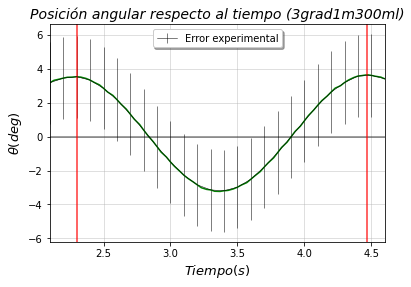

------------------ Péndulo con 3° - 1m ------------------
Los valores tomados como máximos en el ciclo seleccionado son, respectivamente: [3.4  3.41]
El periodo del movimiento es de T=2.2 s
La gravedad del movimiento es de g=8.16 m / s2


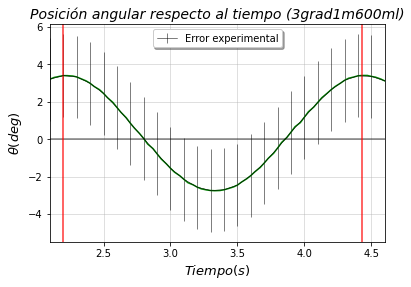

------------------ Péndulo con 11.5° - 1m ------------------
Los valores tomados como máximos en el ciclo seleccionado son, respectivamente: [11.78 11.61]
El periodo del movimiento es de T=2.2 s
La gravedad del movimiento es de g=8.16 m / s2


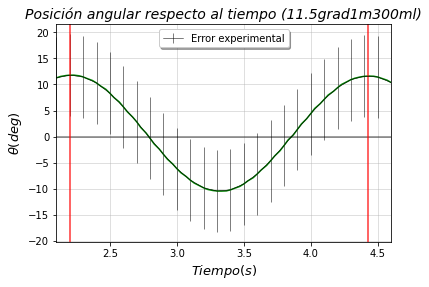

------------------ Péndulo con 11.5° - 1m ------------------
Los valores tomados como máximos en el ciclo seleccionado son, respectivamente: [11.25 11.33]
El periodo del movimiento es de T=2.2 s
La gravedad del movimiento es de g=8.16 m / s2


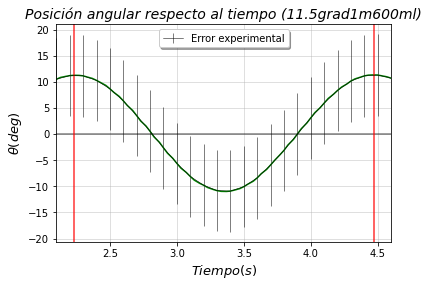

------------------ Péndulo con 3° - 2m ------------------
Los valores tomados como máximos en el ciclo seleccionado son, respectivamente: [3.73 3.71]
El periodo del movimiento es de T=2.9 s
La gravedad del movimiento es de g=9.39 m / s2


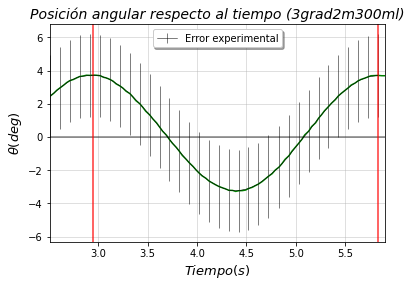

------------------ Péndulo con 3° - 2m ------------------
Los valores tomados como máximos en el ciclo seleccionado son, respectivamente: [2.13 2.37]
El periodo del movimiento es de T=2.8 s
La gravedad del movimiento es de g=10.07 m / s2


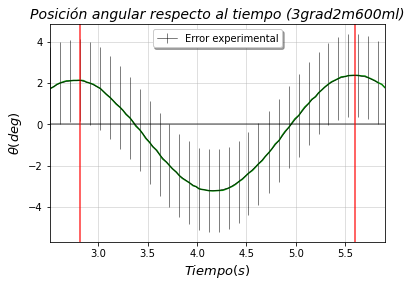

------------------ Péndulo con 11.5° - 2m ------------------
Los valores tomados como máximos en el ciclo seleccionado son, respectivamente: [11.08 10.97]
El periodo del movimiento es de T=2.8 s
La gravedad del movimiento es de g=10.07 m / s2


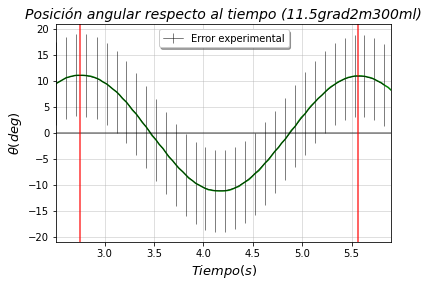

------------------ Péndulo con 11.5° - 2m ------------------
Los valores tomados como máximos en el ciclo seleccionado son, respectivamente: [10.72 10.5 ]
El periodo del movimiento es de T=2.8 s
La gravedad del movimiento es de g=10.07 m / s2


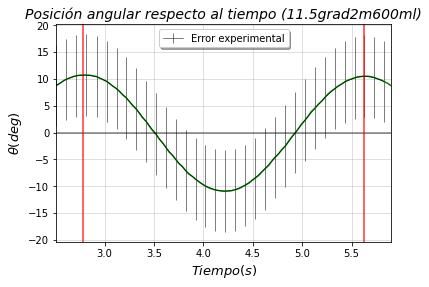

In [3]:
d3grad1m300ml = anDatExp("../Datos/Cuerda 1m/3grados_1m300ml/","_3grad1m300ml.csv", ((2.1,2.4),(4.3,4.6)))

d3grad1m600ml= anDatExp("../Datos/Cuerda 1m/3grados_1m600ml/","_3grad1m600ml.csv", ((2.1,2.4),(4.3,4.6)))

d11_5grad1m300ml = anDatExp("../Datos/Cuerda 1m/11,5grados_1m300ml/","_11.5grad1m300ml.csv", ((2.1,2.4),(4.3,4.6)))

d11_5grad1m600ml = anDatExp("../Datos/Cuerda 1m/11,5grados_1m600ml/","_11.5grad1m600ml.csv", ((2.1,2.4),(4.3,4.6)))

d3grad2m300ml = anDatExp("../Datos/Cuerda 2m/3grad_2m300ml/","_3grad2m300ml.csv", ((2.5,3),(5.3,5.9)))

d3grad2m600ml = anDatExp("../Datos/Cuerda 2m/3grad_2m600ml/","_3grad2m600ml.csv", ((2.5,3),(5.3,5.9)))

d11_5grad2m300ml = anDatExp("../Datos/Cuerda 2m/11,5grad_2m300ml/","_11.5grad2m300ml.csv", ((2.5,3),(5.3,5.9)))

d11_5grad2m600ml = anDatExp("../Datos/Cuerda 2m/11,5grad_2m600ml/","_11.5grad2m600ml.csv", ((2.5,3),(5.3,5.9)))

Finalmente hacemos un promedio de las gravedades para ingresarla como parámetro en la simulación y los periodos para compararlos con las simulaciones.

In [4]:
g = np.array([d3grad1m300ml.g.values[0], d3grad1m600ml.g.values[0], d11_5grad1m300ml.g.values[0],
              d11_5grad1m600ml.g.values[0], d3grad2m300ml.g.values[0], d3grad2m600ml.g.values[0],
              d11_5grad2m300ml.g.values[0], d11_5grad2m600ml.g.values[0]]).mean()
g = g*u.m/u.s**2

T1 = np.array([d3grad1m300ml.Per.values[0], d3grad1m600ml.Per.values[0], d11_5grad1m300ml.Per.values[0],
               d11_5grad1m600ml.Per.values[0]]).mean()
T2 = np.array([d3grad2m300ml.Per.values[0], d3grad2m600ml.Per.values[0], d11_5grad2m300ml.Per.values[0],
               d11_5grad2m600ml.Per.values[0]]).mean()

print("El promedio de la aceleración de gravedad en los datos experimentales es de: g=",
      round(g.value, ndigits=2)*g.unit, sep="")
print("El promedio de periodo en los datos experimentales con longitud de cuerda de 1m es de: T=",
      round(T1, ndigits=1)*u.s, sep="")
print("El promedio de periodo en los datos experimentales con longitud de cuerda de 2m es de: T=",
      round(T2, ndigits=1)*u.s, sep="")

El promedio de la aceleración de gravedad en los datos experimentales es de: g=9.03 m / s2
El promedio de periodo en los datos experimentales con longitud de cuerda de 1m es de: T=2.2 s
El promedio de periodo en los datos experimentales con longitud de cuerda de 2m es de: T=2.8 s


## 1.2. Simulación Teórica

### 1.2.1. Definición de la función (para aproximación con ángulos pequeños)

In [5]:
def simTeoPeq (lon, ang, gra=9.8*u.m/u.s**2, per=1):
    
    """
    Esta función genera una simulación teórica del movimiento de un
    pendulo ingresandole algunos parámetros iniciales. Analiza si
    el ángulo inicial ingresado se encuentra en el rango de ángulos
    cuyo sen(ángulo) es aproximado al mismo ángulo. Todos los valores
    ingresados (a excepción de per) deben tener sus respectivas unidades
    para que no salte un error.
    
    Params:
    lon:
        Longitud de la cuerda. Debe estár en unidades de longitud.
    ang:
        Ángulo inicial del movimiento. Debe estar en unidades angulares.
    gra:
        Aceleración de gravedad. Debe estar en unidades de aceleración.
        Por defecto se usa 9.8m/s^2, pues es el estándar para la tierra.
    per:
        Los periodos o "vueltas" que se quiere simular. Cabe resaltar que
        No va a cambiar mucho entre periodos pues estamos despreciando
        la fricción con el aire. No debe tener unidades. Por defecto: 1.
    
    Returns:
        No hay returns, se imprimen los valores de periodo y velocidad
        angular, así como las gráficas de posición angular, velocidad
        angular y aceleración angular en función del tiempo.
    """
    
    if theta_peq[0]>ang.to("rad").value or ang.to("rad").value>theta_peq[-1]:
        return print("El ángulo está fuera del rango de ángulos considerados pequeños: [",
                     theta_peq[0], ",", theta_peq[-1],"] rad", sep = "")
    
    
    print("-"*18, "Péndulo con "+str(ang.value)+"° - "+str(int(lon.value))+"m "+"-"*18)
    #Disponemos el ángulo en radianes
    print("La amplitud del movimiento es de:", round(ang.to("rad").value, ndigits=3), u.rad)
    
    #Calculamos el periodo, teniendo encuenta que estamos en una aproximación para ángulos pequeños
    T = (2*np.pi*np.sqrt(lon/gra)).to("s")
    print("El periodo del movimiento es T =", round(T.value, ndigits=2)*T.unit)
    
    #Generamos valores de tiempo entre 0 y el periodo del movimiento
    t = np.linspace(0,per*T, 500)

    #Luego, la frecuencia angular para ángulos pequeños
    w = ((2*np.pi)*u.rad/T)
    print("La frecuencia angular del movimiento es w =", round(w.value, ndigits=1)*w.unit)    

    #Ahora, los angulos para cada instante t de tiempo
    angs = (ang.to("rad")*np.cos(w*t))
    
    #Hallamos la velocidad angular (la derivada del tiempo)
    vel = -(ang.to("rad")*w*np.sin(w*t))
    
    #La aceleración angular para ángulos pequeños (solo tomamos en cuenta su magnitud)
    a = (-(gra/lon)*angs.to("rad"))
    
    #Iniciamos la generación de los gráficos
    #Primero la posición angular
    plt.plot(t, angs, color="purple")
    plt.xlabel(r"$Tiempo(s)$", size=13)
    plt.ylabel(r"$\theta(rad)$", size=13)
    plt.axhline(0, color="k", alpha=0.5)
    plt.xlim([0,t[-1].value])
    plt.title("Posición angular respecto al tiempo ("+str(ang.value)+"° - "+str(int(lon.value))+"m)", size=14, fontstyle="oblique")
    plt.grid(alpha=0.5)
    plt.show()
    
    #Ahora velocidad angular
    plt.plot(t, vel, color="purple")
    plt.xlabel(r"$Tiempo(s)$", size=13)
    plt.ylabel(r"$\dot{\theta}(\frac{rad}{s})$", size=13)
    plt.axhline(0, color="k", alpha=0.5)
    plt.xlim([0,t[-1].value])
    plt.title("Velocidad angular respecto al tiempo ("+str(ang.value)+"° - "+str(int(lon.value))+"m)", size=14, fontstyle="oblique")
    plt.grid(alpha=0.5)
    plt.show()
    
    #Por último, aceleración angular
    plt.plot(t, a, color="purple")
    plt.xlabel(r"$Tiempo(s)$", size=13)
    plt.ylabel(r"$\ddot{\theta}(\frac{rad}{s^2})$", size=13)
    plt.axhline(0, color="k", alpha=0.5)
    plt.xlim([0,t[-1].value])
    plt.title("Aceleración angular respecto al tiempo ("+str(ang.value)+"° - "+str(int(lon.value))+"m)", size=14, fontstyle="oblique")
    plt.grid(alpha=0.5)
    plt.show()

### 1.2.2. Simulación con los datos especificados

La simulación teórica con la aceleración de gravedad hallada en el análisis de los datos. Se simula para los ***4 casos diferentes*** en los que varían:
- El ángulo inicial: 3.5°, 11.5° (Los valores varían entre sets de datos)
- La longitud de la cuerda: 1m, 2m  

Se omite la masa (a diferencia de en el análisis de datos), ya que teóricamente no inflye en el movimiento

------------------ Péndulo con 3.5° - 1m ------------------
La amplitud del movimiento es de: 0.061 rad
El periodo del movimiento es T = 2.09 s
La frecuencia angular del movimiento es w = 3.0 rad / s


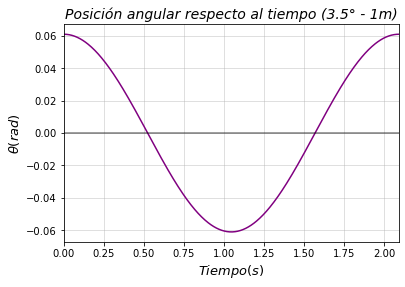

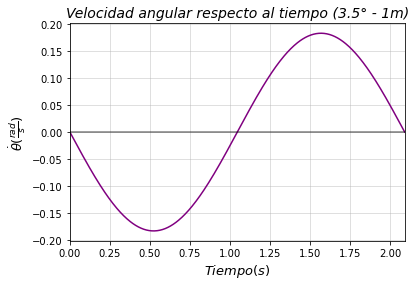

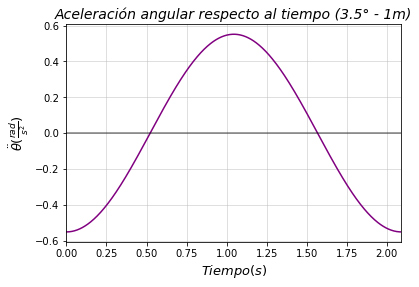

------------------ Péndulo con 11.5° - 1m ------------------
La amplitud del movimiento es de: 0.201 rad
El periodo del movimiento es T = 2.09 s
La frecuencia angular del movimiento es w = 3.0 rad / s


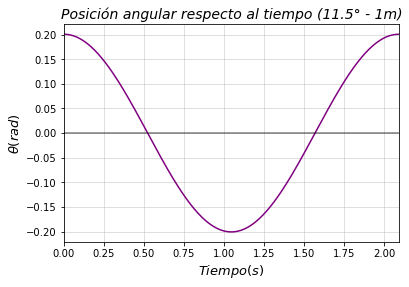

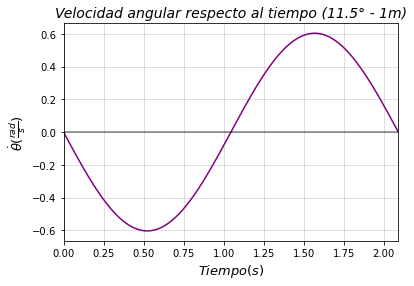

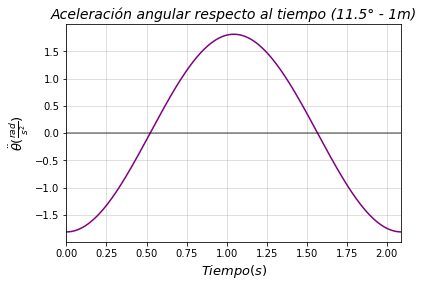

------------------ Péndulo con 3.5° - 2m ------------------
La amplitud del movimiento es de: 0.061 rad
El periodo del movimiento es T = 2.96 s
La frecuencia angular del movimiento es w = 2.1 rad / s


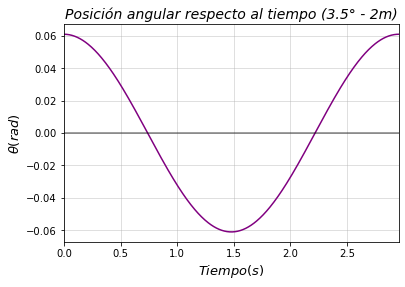

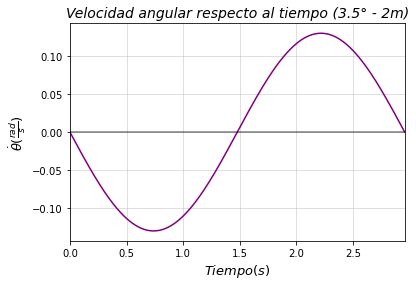

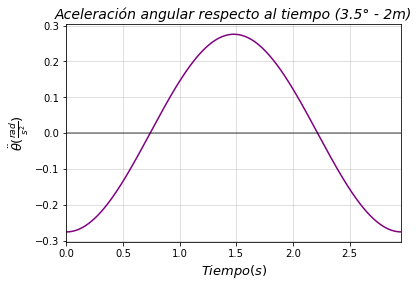

------------------ Péndulo con 11.5° - 2m ------------------
La amplitud del movimiento es de: 0.201 rad
El periodo del movimiento es T = 2.96 s
La frecuencia angular del movimiento es w = 2.1 rad / s


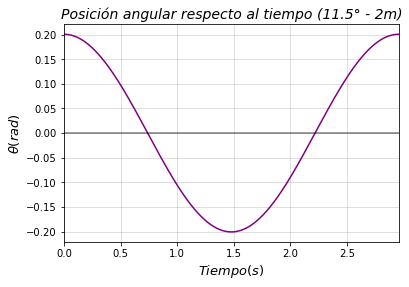

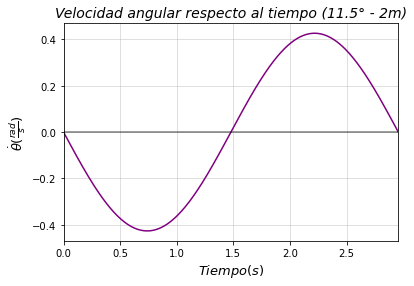

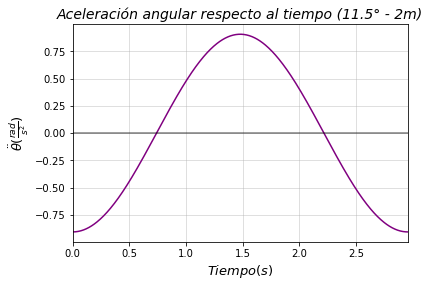

In [6]:
simTeoPeq(1*u.m, 3.5*u.deg, g)    #3.5 grados, 1 metro
simTeoPeq(1*u.m, 11.5*u.deg, g)   #11.5 grados, 1 metro
simTeoPeq(2*u.m, 3.5*u.deg, g)    #3.5 grados, 2 metro
simTeoPeq(2*u.m, 11.5*u.deg, g)   #11.5 grados, 2 metro